In [17]:
import pandas as pd
import json
from aps import compute_ap_return_extra,get_categories_counter,collect_all_predictions,compute_all_aps,get_metrics_by_category
import torch
from matplotlib import pyplot as plt
import numpy as np
import random
%load_ext autoreload
%autoreload 2

df = pd.read_csv('/scratch/fml35/experiments/leveraging_geometry_for_shape/exp_036_s2_predicted_gt_retrieval_gt_T_factor_rotation_vp/global_stats/all_infos.csv')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
angles_by_cat = {"bed": [],"bookcase": [],"chair": [],"desk": [],"misc": [],"sofa": [],"table": [],"tool": [],"wardrobe": []} 

for ind in df.index:
    cat = df["gt_category"][ind]
    angle = df["total_angle_diff"][ind]
    angles_by_cat[cat].append(angle)

In [3]:
scores = torch.Tensor([0.4,0.3,0.1,0.1,0.9,0.9,0.9,0.9,0.7,0.7])
labels = torch.Tensor([0,1,1,1,1,0,0,0,1,1])
npos = 20
ap,rec,prec = compute_ap_return_extra(scores, labels, npos, device=None)

In [20]:
def plot_precision_recall(rec,prec):

    # plt.plot(rec,prec,color='b')
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.show()

    z = rec.new_zeros((1))
    o = rec.new_ones((1))
    mrec = torch.cat((z, rec, o))
    mpre = torch.cat((z, prec, z))

    old_mpre = mpre.clone()

    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])

    I = (mrec[1:] != mrec[0:-1]).nonzero()[:, 0] + 1
    ap = 0
    for i in I:
        ap = ap + (mrec[i] - mrec[i - 1]) * mpre[i]

    I = np.array(I)
    plt.plot(mrec[:-1],mpre[:-1],color='g')
    plt.plot(mrec[:-1],old_mpre[:-1],color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    print('AP:',ap.item())

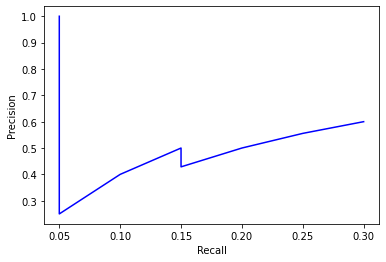

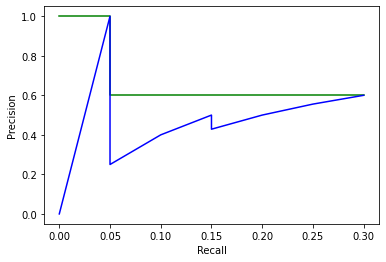

AP: 0.20000001788139343


In [16]:
plot_precision_recall(rec,prec)

In [7]:
global_info = '/scratch/fml35/experiments/leveraging_geometry_for_shape/exp_036_s2_predicted_gt_retrieval_gt_T_factor_rotation_vp/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)

target_folder = global_config["general"]["target_folder"]

metrics = global_config["evaluate_poses"]["metrics"]
thresholds = global_config["evaluate_poses"]["thresholds"]
number_nn = global_config["keypoints"]["matching"]["top_n_retrieval"]
categories = global_config["dataset"]["categories"]

setting_to_metric = {'segmentation': 'avg_dist_furthest', 'keypoints': 'avg_dist_reprojected_keypoints', 'combined':'combined','meshrcnn':'meshrcnn','F1':'F1','factor':'factor'}
setting_to_min_or_max = {'segmentation': 'min', 'keypoints': 'min', 'combined':'min','meshrcnn':'check','F1':'max','factor':'max'}
indicator = setting_to_metric[global_config["pose_and_shape"]["pose"]["choose_best_based_on"]]
min_or_max = setting_to_min_or_max[global_config["pose_and_shape"]["pose"]["choose_best_based_on"]]
categories_counter  = get_categories_counter(target_folder + '/gt_infos',categories)

all_predictions = collect_all_predictions(target_folder,number_nn,indicator)
# filtered_predictions = filter_predictions_mask_score(all_predictions)


metrics_by_category = get_metrics_by_category(all_predictions,metrics,number_nn,thresholds,categories,indicator,min_or_max)

aps = compute_all_aps(metrics_by_category,categories_counter,thresholds)

need to do change in here if want multiple correct predictions per image
collect predictions


100%|██████████| 4025/4025 [00:01<00:00, 2992.61it/s]


In [8]:
aps_mean = {}
for metric in aps:
    aps_mean[metric] = {}
    for category in aps[metric]:
        aps_mean[metric][category] = aps[metric][category]["mean"]

print(aps_mean)

{'F1@0.300000': {'bed': 37.267089039087296, 'bookcase': 28.43796357512474, 'chair': 42.56586134433746, 'desk': 29.490835666656494, 'misc': 3.1120554264634848, 'sofa': 68.03388148546219, 'table': 14.641082510352135, 'tool': 3.016483746469021, 'wardrobe': 53.375200629234314, 'mean': 31.10449482479857}, 'F1@0.500000': {'bed': 55.00335067510605, 'bookcase': 47.09944233298302, 'chair': 66.36605322360992, 'desk': 45.66986471414566, 'misc': 11.98060454800725, 'sofa': 89.36484217643738, 'table': 25.26860460639, 'tool': 5.759948641061783, 'wardrobe': 70.28404831886292, 'mean': 46.31075102628934}, 'F1@0.700000': {'bed': 62.42385268211365, 'bookcase': 54.953052401542664, 'chair': 79.03063774108887, 'desk': 54.80852246284485, 'misc': 27.24786952137947, 'sofa': 94.15331780910492, 'table': 34.12766948342323, 'tool': 11.921157240867615, 'wardrobe': 74.80588436126709, 'mean': 54.830218189292474}}


simulate random scores
Category wardrobe Threshold 50 Metric F1@0.300000


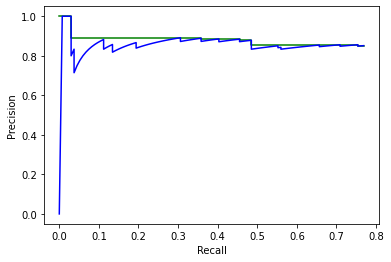

AP: 0.6770886778831482
------------
simulate random scores
Category wardrobe Threshold 50 Metric F1@0.300000


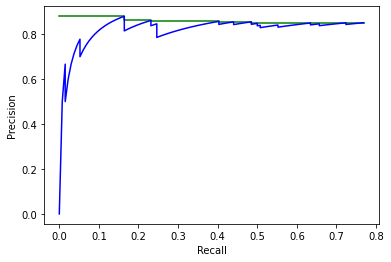

AP: 0.6610401272773743
------------
simulate random scores
Category wardrobe Threshold 50 Metric F1@0.300000


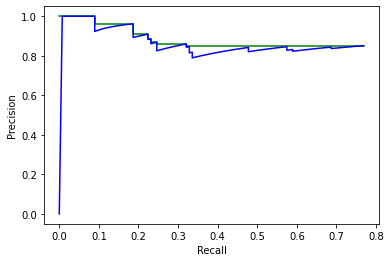

AP: 0.6816603541374207
------------
simulate random scores
Category wardrobe Threshold 50 Metric F1@0.300000


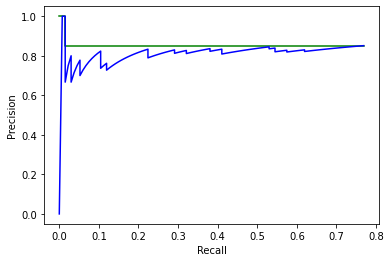

AP: 0.6565321683883667
------------
simulate random scores
Category wardrobe Threshold 50 Metric F1@0.300000


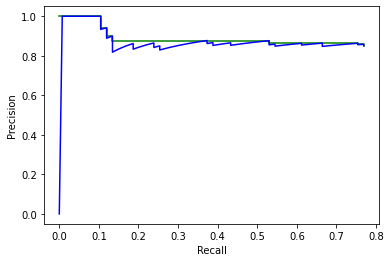

AP: 0.6849923133850098
------------


In [36]:
aps = {}
# could put any threshold here
for metric in metrics_by_category[50]:
    aps[metric] = {}
    for category in metrics_by_category[50][metric]:
        aps[metric][category] = {}

        for threshold in thresholds:
            labels = torch.tensor(metrics_by_category[threshold][metric][category]["F"]) > threshold
            scores = torch.tensor(metrics_by_category[threshold][metric][category]["mask_scores"])

            for i in range(5):
                scores = torch.ones(len(metrics_by_category[threshold][metric][category]["mask_scores"]))
                indices = list(range(len(labels)))
                random.shuffle(indices)

                ap_value,rec,prec = compute_ap_return_extra(scores[indices],labels[indices],categories_counter[category])
                if threshold == 50 and category == 'wardrobe' and metric == 'F1@0.300000':
                    print('simulate random scores')
                    print('Category {} Threshold {} Metric {}'.format(category,threshold,metric))
                    plot_precision_recall(rec,prec)
                    print('------------')
                if torch.is_tensor(ap_value):
                    ap_value = ap_value.item()
                aps[metric][category][threshold] = ap_value * 100
            

        aps[metric][category]["mean"] = np.mean([aps[metric][category][threshold] for threshold in aps[metric][category]])

    aps[metric]["mean"] = {}
    for threshold in range(50,100,5):
        aps[metric]["mean"][threshold] = np.mean([aps[metric][category][threshold] for category in metrics_by_category[50][metric]])
    aps[metric]["mean"]["mean"] = np.mean([aps[metric]["mean"][threshold] for threshold in aps[metric]["mean"]])

In [27]:
aps['F1@0.300000']['table'][50]

22.16787338256836

In [35]:
aps['F1@0.300000']['misc']

{50: 3.725961595773697,
 55: 2.2545455023646355,
 60: 0.9876543655991554,
 65: 1.2378049083054066,
 70: 0.8055555634200573,
 75: 0.33060109708458185,
 80: 0.061728397849947214,
 85: 2.500000037252903,
 90: 0.0,
 95: 0.0,
 'mean': 1.1903851467650384}